In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from scipy import optimize

In [2]:
dependent_var = ["RUL"]
id_columns = ["UnitNumber","Cycle"]
Op_settings_columns = ["OpSet"+str(i) for i in range(1,4)]
sensors_columns = ["Sensor"+str(i) for i in range(1,22)]
input_columns = id_columns + Op_settings_columns + sensors_columns

In [3]:
df_train = pd.read_csv('train_FD001.txt', delim_whitespace=True, names=input_columns)
rul = pd.DataFrame(df_train.groupby("UnitNumber")["Cycle"].max()).reset_index()
rul.columns = ["UnitNumber", "Max_Cycle"]
df_train = df_train.merge(rul, on="UnitNumber", how="left")
df_train["RUL"] = df_train["Max_Cycle"] - df_train["Cycle"]
df_train.drop("Max_Cycle", axis=1, inplace=True)
df_train.head()

UnitNumber  Cycle  OpSet1  OpSet2  OpSet3  Sensor1  Sensor2  Sensor3  \
0           1      1 -0.0007 -0.0004   100.0   518.67   641.82  1589.70   
1           1      2  0.0019 -0.0003   100.0   518.67   642.15  1591.82   
2           1      3 -0.0043  0.0003   100.0   518.67   642.35  1587.99   
3           1      4  0.0007  0.0000   100.0   518.67   642.35  1582.79   
4           1      5 -0.0019 -0.0002   100.0   518.67   642.37  1582.85   

   Sensor4  Sensor5  ...  Sensor13  Sensor14  Sensor15  Sensor16  Sensor17  \
0  1400.60    14.62  ...   2388.02   8138.62    8.4195      0.03       392   
1  1403.14    14.62  ...   2388.07   8131.49    8.4318      0.03       392   
2  1404.20    14.62  ...   2388.03   8133.23    8.4178      0.03       390   
3  1401.87    14.62  ...   2388.08   8133.83    8.3682      0.03       392   
4  1406.22    14.62  ...   2388.04   8133.80    8.4294      0.03       393   

   Sensor18  Sensor19  Sensor20  Sensor21  RUL  
0      2388     100.0     39.06   23.4190  191  
1      2388     100.0     39.00   23.4236  190  
2      2388     100.0     38.95   23.3442  189  
3      2388     100.0     38.88   23.3739  188  
4      2388     100.0     38.90   23.4044  187  

[5 rows x 27 columns]

In [4]:
df_test = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=input_columns)
df_test.head()

UnitNumber  Cycle  OpSet1  OpSet2  OpSet3  Sensor1  Sensor2  Sensor3  \
0           1      1  0.0023  0.0003   100.0   518.67   643.02  1585.29   
1           1      2 -0.0027 -0.0003   100.0   518.67   641.71  1588.45   
2           1      3  0.0003  0.0001   100.0   518.67   642.46  1586.94   
3           1      4  0.0042  0.0000   100.0   518.67   642.44  1584.12   
4           1      5  0.0014  0.0000   100.0   518.67   642.51  1587.19   

   Sensor4  Sensor5  ...  Sensor12  Sensor13  Sensor14  Sensor15  Sensor16  \
0  1398.21    14.62  ...    521.72   2388.03   8125.55    8.4052      0.03   
1  1395.42    14.62  ...    522.16   2388.06   8139.62    8.3803      0.03   
2  1401.34    14.62  ...    521.97   2388.03   8130.10    8.4441      0.03   
3  1406.42    14.62  ...    521.38   2388.05   8132.90    8.3917      0.03   
4  1401.92    14.62  ...    522.15   2388.03   8129.54    8.4031      0.03   

   Sensor17  Sensor18  Sensor19  Sensor20  Sensor21  
0       392      2388     100.0     38.86   23.3735  
1       393      2388     100.0     39.02   23.3916  
2       393      2388     100.0     39.08   23.4166  
3       391      2388     100.0     39.00   23.3737  
4       390      2388     100.0     38.99   23.4130  

[5 rows x 26 columns]

In [5]:
y_true = pd.read_csv('RUL_FD001.txt', delim_whitespace=True, names=['RUL'])
y_true["UnitNumber"] = y_true.index + 1
y_true.head()

RUL  UnitNumber
0  112           1
1   98           2
2   69           3
3   82           4
4   91           5

In [6]:
df_train.isnull().sum()

UnitNumber    0
Cycle         0
OpSet1        0
OpSet2        0
OpSet3        0
Sensor1       0
Sensor2       0
Sensor3       0
Sensor4       0
Sensor5       0
Sensor6       0
Sensor7       0
Sensor8       0
Sensor9       0
Sensor10      0
Sensor11      0
Sensor12      0
Sensor13      0
Sensor14      0
Sensor15      0
Sensor16      0
Sensor17      0
Sensor18      0
Sensor19      0
Sensor20      0
Sensor21      0
RUL           0
dtype: int64

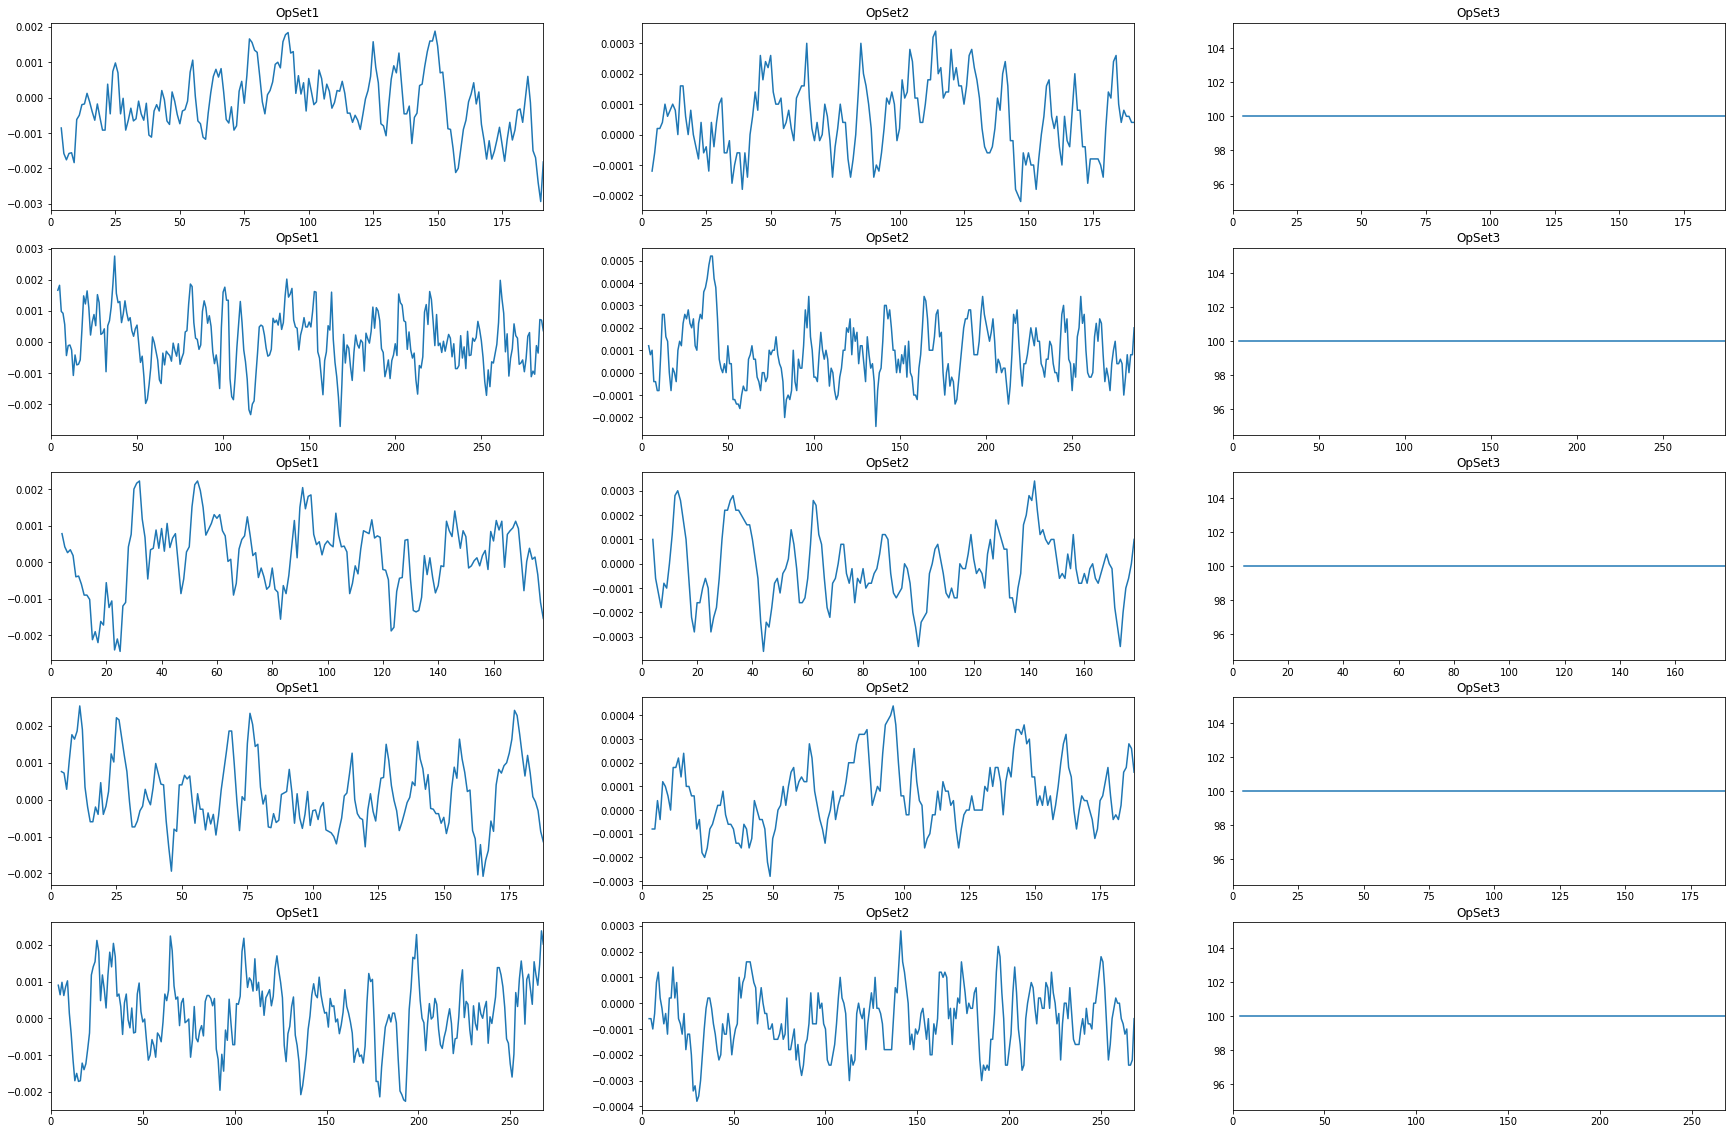

In [7]:
fig,ax=plt.subplots(5,3, figsize=(30,20))
for i in range(0,5):
    for j in range(0,3):
        df= df_train.query('UnitNumber=='+str(i+1)).reset_index(drop=True)
        df['rolling_avg'] = df['OpSet'+str(j+1)].rolling(window = 5).mean()
        df['rolling_avg'].plot(kind = "line", ax = ax[i][j])
        ax[i][j].set_title('OpSet'+str(j+1))

Each unit operates under different conditions,characterized by three dimensions which change over time (e.g. altitude or external air pressure). The figure above shows the values of these operational conditions over time for five units;
Operational Settings 1 and 2 do not show clear signal of failure but they might be important. Operational Setting 3 remains same throughout engine's life. Also, its value is same (i.e. 100) among all units. Therefore, we can drop this feature.

In [8]:
std_df= df_train.groupby('UnitNumber').std()
std_df.head()

Cycle    OpSet1    OpSet2  OpSet3  Sensor1   Sensor2  \
UnitNumber                                                             
1           55.569776  0.001953  0.000282     0.0      0.0  0.486795   
2           82.993976  0.002320  0.000298     0.0      0.0  0.560214   
3           51.816986  0.002145  0.000290     0.0      0.0  0.474190   
4           54.703748  0.002033  0.000286     0.0      0.0  0.441446   
5           77.797815  0.002119  0.000279     0.0      0.0  0.551542   

             Sensor3   Sensor4  Sensor5   Sensor6  ...  Sensor13   Sensor14  \
UnitNumber                                         ...                        
1           5.759776  8.565610      0.0  0.000000  ...  0.076960   5.563129   
2           6.596730  9.737248      0.0  0.002491  ...  0.063861   8.683012   
3           6.386222  8.610126      0.0  0.001482  ...  0.041219  29.439715   
4           6.109152  7.737463      0.0  0.000727  ...  0.034819  30.691780   
5           7.060648  9.782341      0.0  0.002503  ...  0.056445  16.480153   

            Sensor15  Sensor16  Sensor17  Sensor18  Sensor19  Sensor20  \
UnitNumber                                                               
1           0.034125       0.0  1.475661       0.0       0.0  0.166998   
2           0.041128       0.0  1.647280       0.0       0.0  0.199332   
3           0.036620       0.0  1.570773       0.0       0.0  0.166112   
4           0.031947       0.0  1.602848       0.0       0.0  0.159302   
5           0.038658       0.0  1.740057       0.0       0.0  0.187133   

            Sensor21        RUL  
UnitNumber                       
1           0.105101  55.569776  
2           0.114796  82.993976  
3           0.104734  51.816986  
4           0.093804  54.703748  
5           0.112705  77.797815  

[5 rows x 26 columns]

In [9]:
std_df.sum(axis = 0) == 0

Cycle       False
OpSet1      False
OpSet2      False
OpSet3       True
Sensor1      True
Sensor2     False
Sensor3     False
Sensor4     False
Sensor5      True
Sensor6     False
Sensor7     False
Sensor8     False
Sensor9     False
Sensor10     True
Sensor11    False
Sensor12    False
Sensor13    False
Sensor14    False
Sensor15    False
Sensor16     True
Sensor17    False
Sensor18     True
Sensor19     True
Sensor20    False
Sensor21    False
RUL         False
dtype: bool

Sensor1, Sensor5, Sensor10, Sensore16, Sensor18 and Sensor19 do not add value and we can remove them from analysis to reduce the complexity of our model.

In [10]:
df_train.Sensor6.value_counts()

21.61    20225
21.60      406
Name: Sensor6, dtype: int64

Sensor 6 remains almost constant as well with some minor fluctuations and we can remove it as well.

Now we remove unnecessary features to optimize analysis

In [12]:
unnecessary_feats = ['Sensor1','Sensor5','Sensor6','Sensor10','Sensor16','Sensor18','Sensor19']
feats = [feat for feat in sensors_columns if feat not in unnecessary_feats]
feats

['Sensor2',
 'Sensor3',
 'Sensor4',
 'Sensor7',
 'Sensor8',
 'Sensor9',
 'Sensor11',
 'Sensor12',
 'Sensor13',
 'Sensor14',
 'Sensor15',
 'Sensor17',
 'Sensor20',
 'Sensor21']

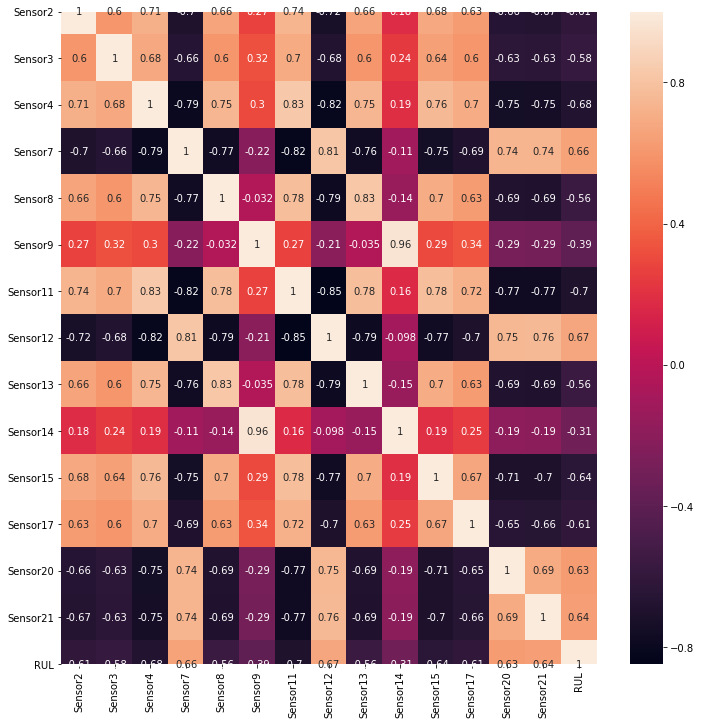

In [70]:
corr = df_train[feats + ['RUL']].corr()
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax = sns.heatmap(corr, annot=True)

As we can see, Sensor 14 and Sensor 9 are higly correlated.

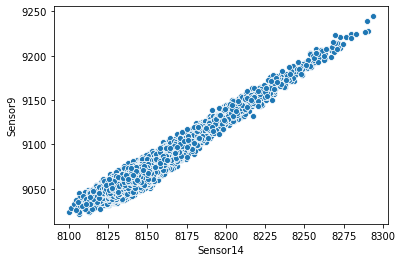

In [71]:
sns.scatterplot(x = df_train.Sensor14, y = df_train.Sensor9)

Since both of these sensors are highly correlated with eachother and Sensor Measure 9 is higly correlated with RUL, we drop Sensor Measure 14.

In [13]:
feats = [i for i in feats if "Sensor14" not in i]
feats

['Sensor2',
 'Sensor3',
 'Sensor4',
 'Sensor7',
 'Sensor8',
 'Sensor9',
 'Sensor11',
 'Sensor12',
 'Sensor13',
 'Sensor15',
 'Sensor17',
 'Sensor20',
 'Sensor21']

In [14]:
features = ['OpSet1'] + ['OpSet2'] + feats
features

['OpSet1',
 'OpSet2',
 'Sensor2',
 'Sensor3',
 'Sensor4',
 'Sensor7',
 'Sensor8',
 'Sensor9',
 'Sensor11',
 'Sensor12',
 'Sensor13',
 'Sensor15',
 'Sensor17',
 'Sensor20',
 'Sensor21']

In [15]:
cols_to_drop = ['OpSet3', 'Sensor1', 'Sensor5', 'Sensor6', 'Sensor10', 'Sensor14',
     'Sensor16', 'Sensor18', 'Sensor19']
df_train = df_train.drop(cols_to_drop, axis = 1)
df_test = df_test.drop(cols_to_drop, axis = 1)

In [17]:
df_train.shape, df_test.shape, y_true.shape

((20631, 18), (13096, 17), (100, 2))

In [18]:
sc = MinMaxScaler(feature_range=(-1,1))

df_train[features] = sc.fit_transform(df_train[features])
df_test[features] = sc.transform(df_test[features])

In [19]:
df_train.head()

UnitNumber  Cycle    OpSet1    OpSet2   Sensor2   Sensor3   Sensor4  \
0           1      1 -0.080460 -0.666667 -0.632530 -0.186396 -0.380486   
1           1      2  0.218391 -0.500000 -0.433735 -0.093961 -0.294733   
2           1      3 -0.494253  0.500000 -0.313253 -0.260955 -0.258947   
3           1      4  0.080460  0.000000 -0.313253 -0.487683 -0.337610   
4           1      5 -0.218391 -0.333333 -0.301205 -0.485066 -0.190749   

    Sensor7   Sensor8   Sensor9  Sensor11  Sensor12  Sensor13  Sensor15  \
0  0.452496 -0.515152 -0.780490 -0.261905  0.266525 -0.588235 -0.272028   
1  0.256039 -0.575758 -0.799515 -0.238095  0.530917 -0.441176 -0.177376   
2  0.420290 -0.454545 -0.719914 -0.500000  0.590618 -0.558824 -0.285110   
3  0.481481 -0.363636 -0.750965 -0.666667  0.778252 -0.411765 -0.666795   
4  0.336554 -0.515152 -0.700081 -0.488095  0.492537 -0.529412 -0.195845   

   Sensor17  Sensor20  Sensor21  RUL  
0 -0.333333  0.426357  0.449323  191  
1 -0.333333  0.333333  0.462027  190  
2 -0.666667  0.255814  0.242751  189  
3 -0.333333  0.147287  0.324772  188  
4 -0.166667  0.178295  0.409003  187

In [20]:
df_test.head()

UnitNumber  Cycle    OpSet1    OpSet2   Sensor2   Sensor3   Sensor4  \
0           1      1  0.264368  0.500000  0.090361 -0.378679 -0.461175   
1           1      2 -0.310345 -0.500000 -0.698795 -0.240898 -0.555368   
2           1      3  0.034483  0.166667 -0.246988 -0.306736 -0.355503   
3           1      4  0.482759  0.000000 -0.259036 -0.429693 -0.183997   
4           1      5  0.160920  0.000000 -0.216867 -0.295836 -0.335922   

    Sensor7   Sensor8   Sensor9  Sensor11  Sensor12  Sensor13  Sensor15  \
0  0.304348 -0.575758 -0.744773 -0.583333  0.292111 -0.558824 -0.382070   
1  0.610306 -0.666667 -0.706632 -0.226190  0.479744 -0.470588 -0.573682   
2  0.371981 -0.545455 -0.683837 -0.226190  0.398721 -0.558824 -0.082724   
3  0.359098 -0.606061 -0.788567 -0.488095  0.147122 -0.500000 -0.485956   
4  0.388084 -0.666667 -0.795208 -0.452381  0.475480 -0.558824 -0.398230   

   Sensor17  Sensor20  Sensor21  
0 -0.333333  0.116279  0.323667  
1 -0.166667  0.364341  0.373654  
2 -0.166667  0.457364  0.442695  
3 -0.500000  0.333333  0.324220  
4 -0.666667  0.317829  0.432753

In [21]:
#Reduce noise using rolling averages
df_train_mean = df_train.groupby('UnitNumber')[features].rolling(window = 5).mean()
df_train_mean = df_train_mean.reset_index()
df_train_mean.dropna(inplace = True)
df_train_mean.drop(['level_1'], axis = 1, inplace = True)
df_train_mean.head()

UnitNumber    OpSet1    OpSet2   Sensor2   Sensor3   Sensor4   Sensor7  \
4           1 -0.098851 -0.200000 -0.398795 -0.302812 -0.292505  0.389372   
5           1 -0.181609 -0.100000 -0.365060 -0.348419 -0.307562  0.409340   
6           1 -0.202299  0.033333 -0.325301 -0.344059 -0.343822  0.447343   
7           1 -0.181609  0.033333 -0.300000 -0.387922 -0.365631  0.420934   
8           1 -0.179310  0.066667 -0.327711 -0.316503 -0.413369  0.371981   

    Sensor8   Sensor9  Sensor11  Sensor12  Sensor13  Sensor15  Sensor17  \
4 -0.484848 -0.750193 -0.430952  0.531770 -0.505882 -0.319431 -0.366667   
5 -0.509091 -0.743929 -0.504762  0.533475 -0.500000 -0.332820 -0.400000   
6 -0.521212 -0.716899 -0.535714  0.536887 -0.523529 -0.385764 -0.400000   
7 -0.569697 -0.738688 -0.542857  0.541151 -0.523529 -0.401462 -0.366667   
8 -0.606061 -0.744108 -0.504762  0.449893 -0.541176 -0.394382 -0.366667   

   Sensor20  Sensor21  
4  0.268217  0.377575  
5  0.243411  0.348799  
6  0.274419  0.323281  
7  0.280620  0.304722  
8  0.333333  0.322784

In [22]:
df_train_mean.shape

(20231, 16)

Selecting features using monotonicity

In [23]:
df_diff = df_train_mean.groupby('UnitNumber').diff()
df_diff['UnitNumber']=df_train_mean['UnitNumber']
df_diff.dropna(inplace=True)
df_diff = df_diff.reset_index(drop=True)
df_diff.head()

OpSet1        OpSet2   Sensor2   Sensor3   Sensor4   Sensor7   Sensor8  \
0 -0.082759  1.000000e-01  0.033735 -0.045607 -0.015057  0.019968 -0.024242   
1 -0.020690  1.333333e-01  0.039759  0.004360 -0.036259  0.038003 -0.012121   
2  0.020690  6.938894e-18  0.025301 -0.043863 -0.021810 -0.026409 -0.048485   
3  0.002299  3.333333e-02 -0.027711  0.071419 -0.047738 -0.048953 -0.036364   
4 -0.032184  1.000000e-01 -0.079518  0.073163 -0.038893 -0.026409 -0.006061   

    Sensor9  Sensor11  Sensor12  Sensor13  Sensor15  Sensor17  Sensor20  \
0  0.006264 -0.073810  0.001706  0.005882 -0.013390 -0.033333 -0.024806   
1  0.027030 -0.030952  0.003412 -0.023529 -0.052943  0.000000  0.031008   
2 -0.021789 -0.007143  0.004264  0.000000 -0.015698  0.033333  0.006202   
3 -0.005420  0.038095 -0.091258 -0.017647  0.007080  0.000000  0.052713   
4 -0.006192 -0.059524 -0.034115  0.011765 -0.001231  0.000000  0.015504   

   Sensor21  UnitNumber  
0 -0.028777           1  
1 -0.025518           1  
2 -0.018558           1  
3  0.018061           1  
4  0.035902           1

In [24]:
def monotonicity(data):
    num_pos = data[data > 0].shape[0]
    num_neg = data[data < 0].shape[0]
    tot_n = data.shape[0] - 1
    mon_val = np.abs(num_pos - num_neg)/tot_n
    return mon_val

In [25]:
mon_df = pd.DataFrame(columns = ['feature', 'monotonicity_val'])
for col in features :
    mon_val =[]
    for unit in df_diff.UnitNumber.unique():
        mon_val.append(monotonicity(df_diff.loc[df_diff.UnitNumber == unit, col]))
    mon_df = mon_df.append({'feature': col, 'monotonicity_val': np.mean(mon_val)},ignore_index = True)

In [26]:
mon_df = mon_df.sort_values(by = 'monotonicity_val', ascending=False)
mon_df.head()

feature  monotonicity_val
7    Sensor9          0.147807
8   Sensor11          0.116696
9   Sensor12          0.105777
4    Sensor4          0.092576
10  Sensor13          0.086236

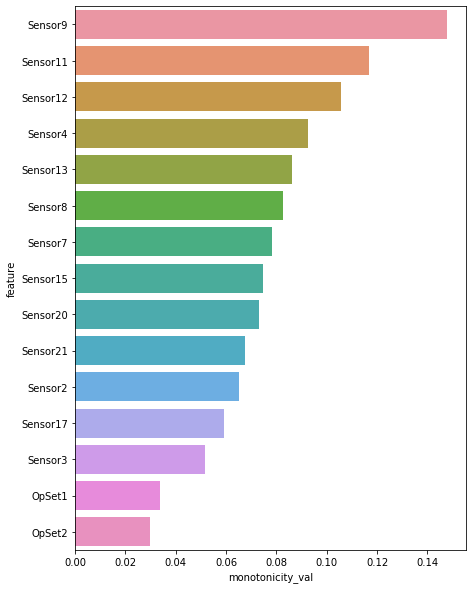

In [27]:
fig,ax = plt.subplots(figsize = (7,10))
sns.barplot(y=mon_df.feature, x=mon_df.monotonicity_val)

select only the features with monotonicity value larger than 0.08

In [29]:
feats = mon_df.feature[mon_df.monotonicity_val > 0.08]
feats

7      Sensor9
8     Sensor11
9     Sensor12
4      Sensor4
10    Sensor13
6      Sensor8
Name: feature, dtype: object

In [128]:
len(feats)

6

Applying Principal Component Analysis to fuse features

In [30]:
from sklearn.decomposition import PCA

In [31]:
pca = PCA(n_components = 3)
pca_data = pca.fit_transform(df_train_mean[feats])
pca_df = pd.DataFrame(pca_data, columns = ['PC1', 'PC2', 'PC3'])
pca_df['UnitNumber'] = df_train_mean.UnitNumber.values
pca_df['Cycle']=pca_df.groupby('UnitNumber').cumcount()+1
pca_df['RUL'] = pca_df.groupby('UnitNumber').Cycle.transform('max') - pca_df.Cycle
pca_df.head()

PC1       PC2       PC3  UnitNumber  Cycle  RUL
0 -0.492292 -0.111834 -0.125100           1      1  187
1 -0.544931 -0.110194 -0.120761           1      2  186
2 -0.590167 -0.083968 -0.095534           1      3  185
3 -0.624496 -0.093633 -0.080571           1      4  184
4 -0.598887 -0.087219  0.022424           1      5  183

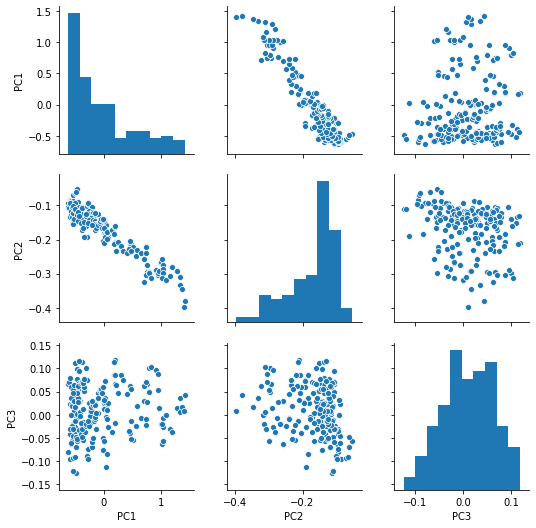

In [32]:
pcs = ['PC1', 'PC2', 'PC3']
sns.pairplot(data = pca_df[pca_df.UnitNumber == 1], x_vars = pcs, y_vars = pcs)

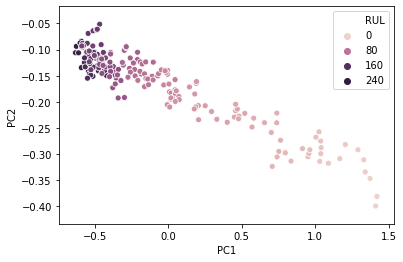

In [33]:
sns.scatterplot(data=pca_df[pca_df.UnitNumber == 1], x = "PC1", y = "PC2", hue = "RUL")

Let's consider PC1 as a health indicator and visualize it against cycle

Text(0, 0.5, 'Health Indicator')

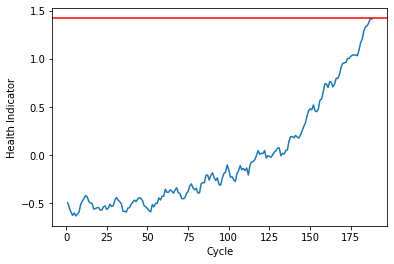

In [34]:
fig,ax = plt.subplots()
sns.lineplot(data = pca_df[pca_df.UnitNumber == 1], x = "Cycle", y = 'PC1', ax = ax)
plt.axhline(pca_df[pca_df.UnitNumber == 1].PC1.max(), color ='r')
ax.set_ylabel("Health Indicator")

Visualizing health indicators for all the units

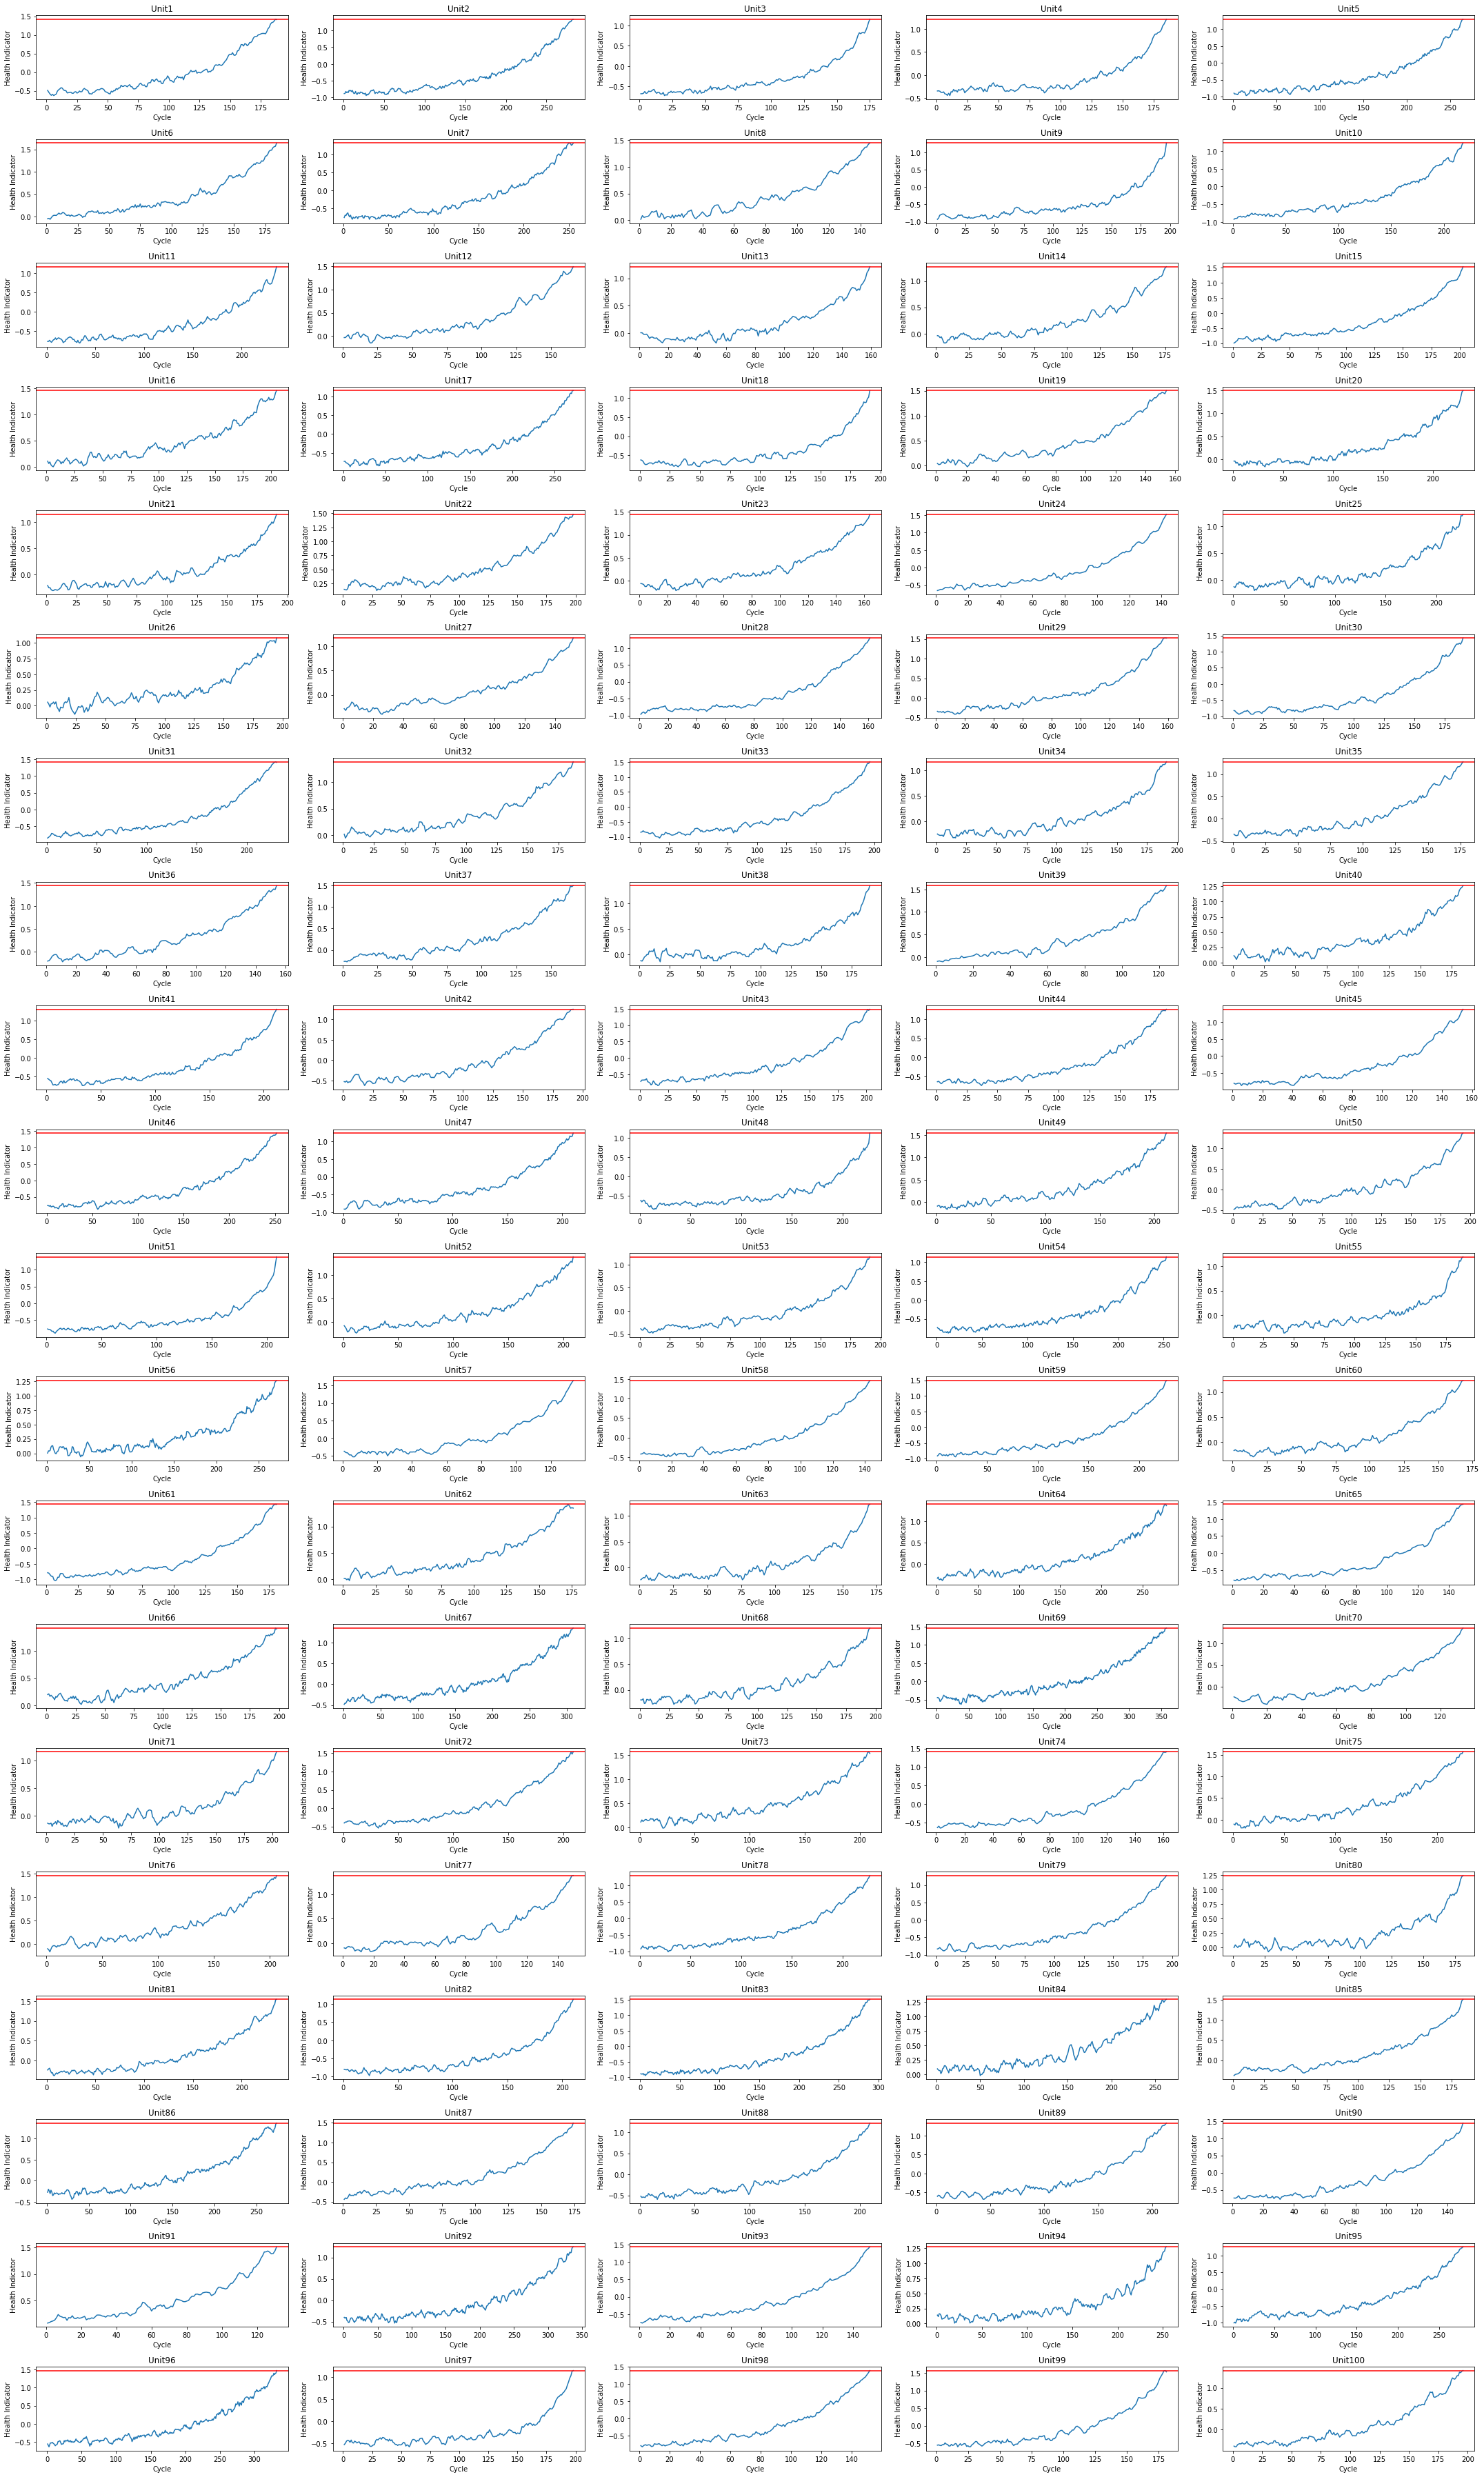

In [35]:
fig, ax = plt.subplots(nrows = 20, ncols = 5, figsize = (30,50))
ax = ax.ravel()
for i in range(0,100):
    sns.lineplot(data = pca_df[pca_df.UnitNumber == i+1], x = "Cycle", y = "PC1", ax = ax[i])
    ax[i].axhline(pca_df[pca_df.UnitNumber == i+1].PC1.max(), color = 'r')
    ax[i].set_ylabel("Health Indicator")
    ax[i].set_title("Unit"+str(i+1))
plt.tight_layout()

for the failure threshold, we are going to take a mean health indicator value at RUL=0 as a failure threshold

In [36]:
threshold = pca_df.PC1[pca_df.RUL == 0].mean()
threshold

1.3567051745446719

In [37]:
threshold_std = pca_df.PC1[pca_df.RUL == 0].std()
threshold_std

0.1352990722328605

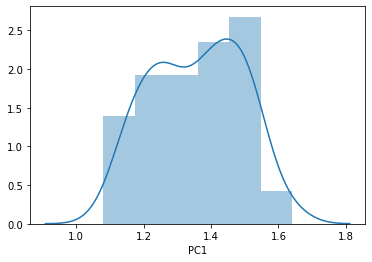

In [38]:
sns.distplot(pca_df.PC1[pca_df.RUL == 0])

In [39]:
pca_df.PC1[pca_df.RUL == 0]

187      1.411023
470      1.333859
645      1.149970
830      1.211352
1095     1.293617
           ...   
19503    1.464036
19701    1.147845
19853    1.392423
20034    1.531732
20230    1.408500
Name: PC1, Length: 100, dtype: float64

Exponential Degradation Model

In [40]:
def degradation_model(parameters, cycle):
    phi = parameters[0]
    theta = parameters[1]
    beta = parameters[2]
    ht = phi + theta*np.exp(beta*cycle)
    return ht

In [41]:
def residuals(parameters, data, y_observed, func):
    return func(parameters, data) - y_observed

In [42]:
#initial values of parameters
param_0 = [-1,0.01,0.01]

In [43]:
exp_param_df = pd.DataFrame(columns=['UnitNumber', 'phi', 'theta', 'beta'])
for i in range(1,101):
    ht = pca_df.PC1[pca_df.UnitNumber == i]
    cycle = pca_df.Cycle[pca_df.UnitNumber == i]
    OptimizeResult = optimize.least_squares(residuals, param_0, args = (cycle,ht,degradation_model))
    phi, theta, beta = OptimizeResult.x
    exp_param_df = exp_param_df.append({'UnitNumber': i, 'phi': phi, 'theta' : theta, 'beta' : beta}, ignore_index = True)

In [44]:
exp_param_df.head()

UnitNumber       phi     theta      beta
0         1.0 -0.630867  0.065722  0.018402
1         2.0 -0.915214  0.046636  0.013727
2         3.0 -0.641808  0.013912  0.027364
3         4.0 -0.331222  0.004062  0.032040
4         5.0 -0.918054  0.046292  0.014482

Text(0, 0.5, 'Health Indicator')

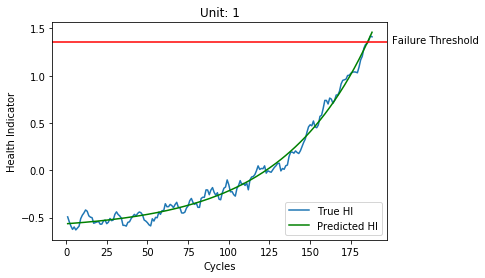

In [45]:
phi = exp_param_df.phi[exp_param_df.UnitNumber == 1].values
theta = exp_param_df.theta[exp_param_df.UnitNumber == 1].values
beta = exp_param_df.beta[exp_param_df.UnitNumber == 1].values
cycle = pca_df.Cycle[pca_df.UnitNumber == 1].values
pred_hi = degradation_model([phi,theta,beta],cycle)
fig, ax = plt.subplots()
sns.lineplot(data=pca_df[pca_df.UnitNumber == 1], x= 'Cycle', y='PC1', ax = ax, label = "True HI")
sns.lineplot(y = pred_hi, x= cycle, ax = ax, label = 'Predicted HI', color = 'green')
ax.axhline(threshold, color = 'r')
ax.text(200,threshold - 0.01,'Failure Threshold',rotation=0)
ax.set_title("Unit: 1")
ax.set_xlabel("Cycles")
ax.set_ylabel("Health Indicator")

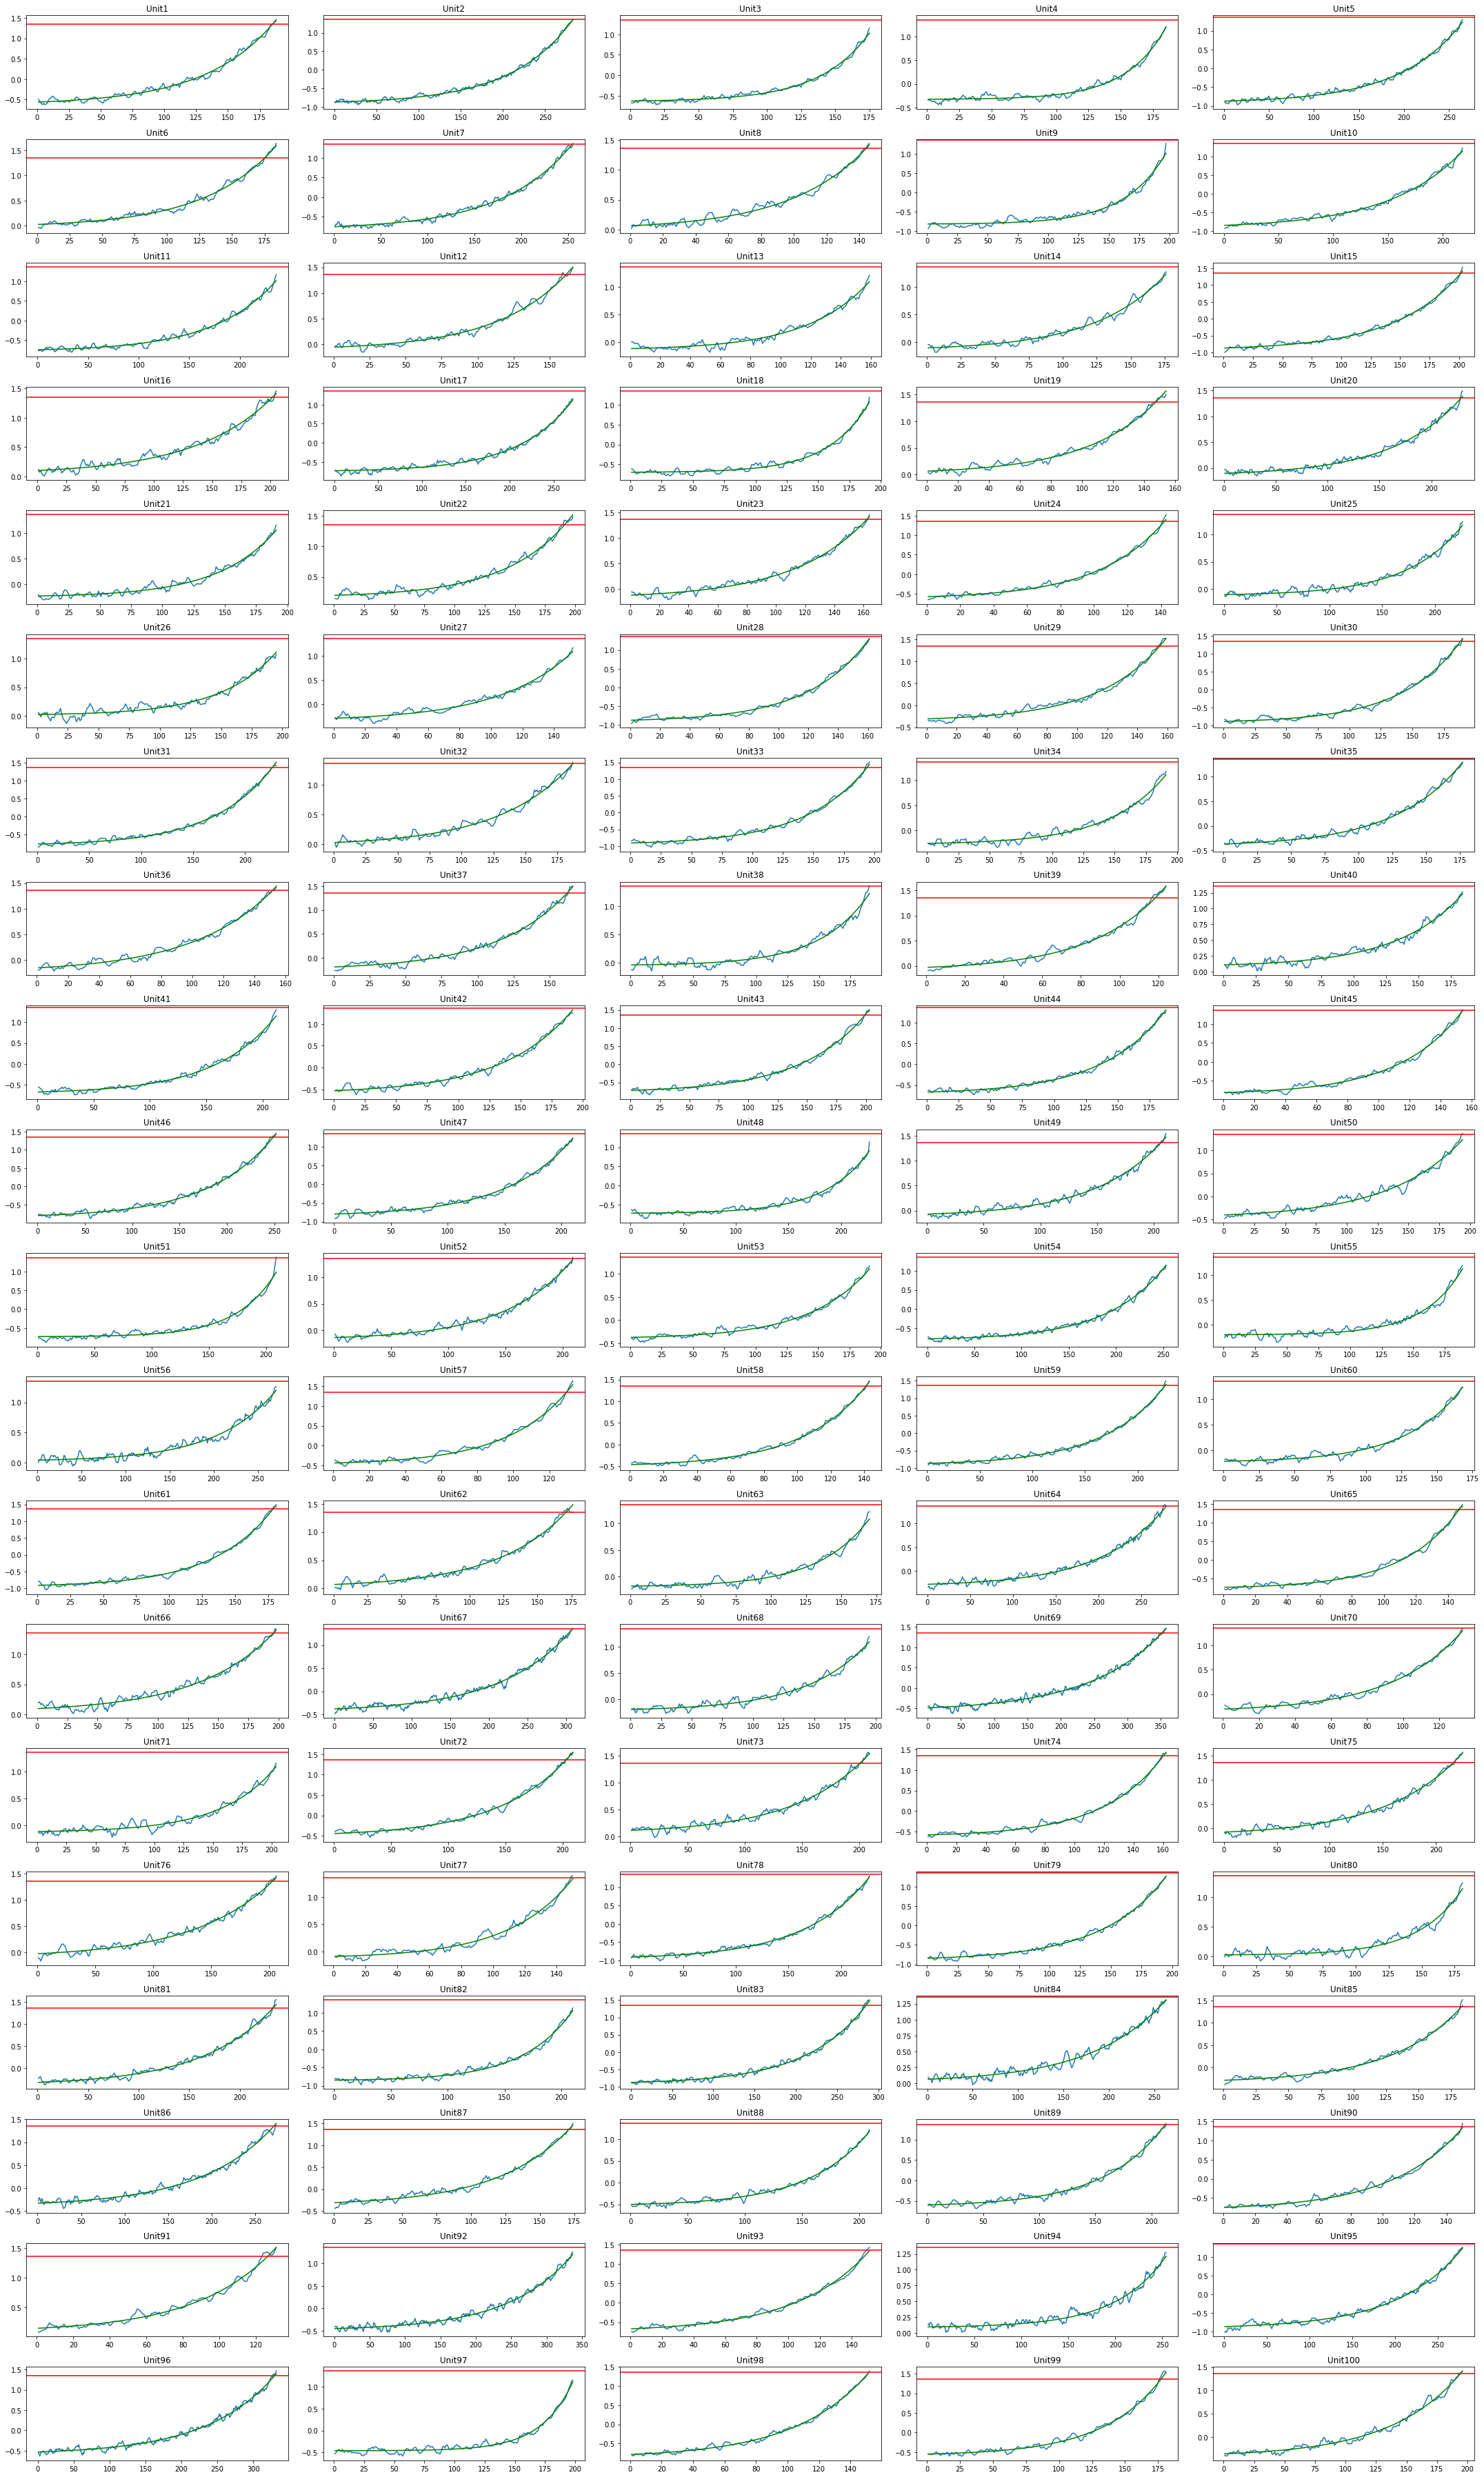

In [46]:
#Visualizing fitted exponential curve for all units
fig, ax = plt.subplots(nrows = 20, ncols = 5, figsize =(30,50))
ax = ax.ravel()
for i in range(0,100):
    phi = exp_param_df.phi[exp_param_df.UnitNumber == i+1].values
    theta = exp_param_df.theta[exp_param_df.UnitNumber == i+1].values
    beta = exp_param_df.beta[exp_param_df.UnitNumber == i+1].values
    cycle = pca_df.Cycle[pca_df.UnitNumber == i+1].values
    pred_hi = degradation_model([phi,theta,beta],cycle)
    sns.lineplot(data=pca_df[pca_df.UnitNumber == i+1], y='PC1', x='Cycle', ax = ax[i])
    sns.lineplot(y=pred_hi, x=cycle, ax= ax[i], color= 'green')
    ax[i].axhline(threshold, color = 'r')
    ax[i].set_title("Unit"+str(i+1))
    ax[i].set_ylabel("")
    ax[i].set_xlabel("")
plt.tight_layout()

Preparing test data

In [47]:
df_test_mean = df_test.groupby('UnitNumber')[feats].rolling(window=5).mean()
df_test_mean = df_test_mean.reset_index()
df_test_mean.dropna(inplace=True)
df_test_mean.drop(['level_1'], axis= 1, inplace = True)
df_test_mean.head()

UnitNumber   Sensor9  Sensor11  Sensor12   Sensor4  Sensor13   Sensor8
4           1 -0.743803 -0.395238  0.358635 -0.378393 -0.529412 -0.612121
5           1 -0.742385 -0.380952  0.375693 -0.399190 -0.500000 -0.636364
6           1 -0.747824 -0.426190  0.362900 -0.335584 -0.500000 -0.612121
7           1 -0.755183 -0.495238  0.373134 -0.338623 -0.482353 -0.612121
8           1 -0.749331 -0.473810  0.428571 -0.299055 -0.482353 -0.593939

In [48]:
#Extracting Principal Components from the dataset
pca_test_data = pca.transform(df_test_mean[feats])
pca_test_df = pd.DataFrame(pca_test_data, columns = ["PC1", "PC2", "PC3"])
pca_test_df['UnitNumber'] = df_test_mean.UnitNumber.values
pca_test_df['Cycle'] = pca_test_df.groupby('UnitNumber').cumcount()+1
pca_test_df.head()

PC1       PC2       PC3  UnitNumber  Cycle
0 -0.475481 -0.073749  0.068525           1      1
1 -0.485190 -0.075330  0.074429           1      2
2 -0.463893 -0.082392  0.029234           1      3
3 -0.501751 -0.100937  0.016013           1      4
4 -0.493346 -0.092624 -0.048555           1      5

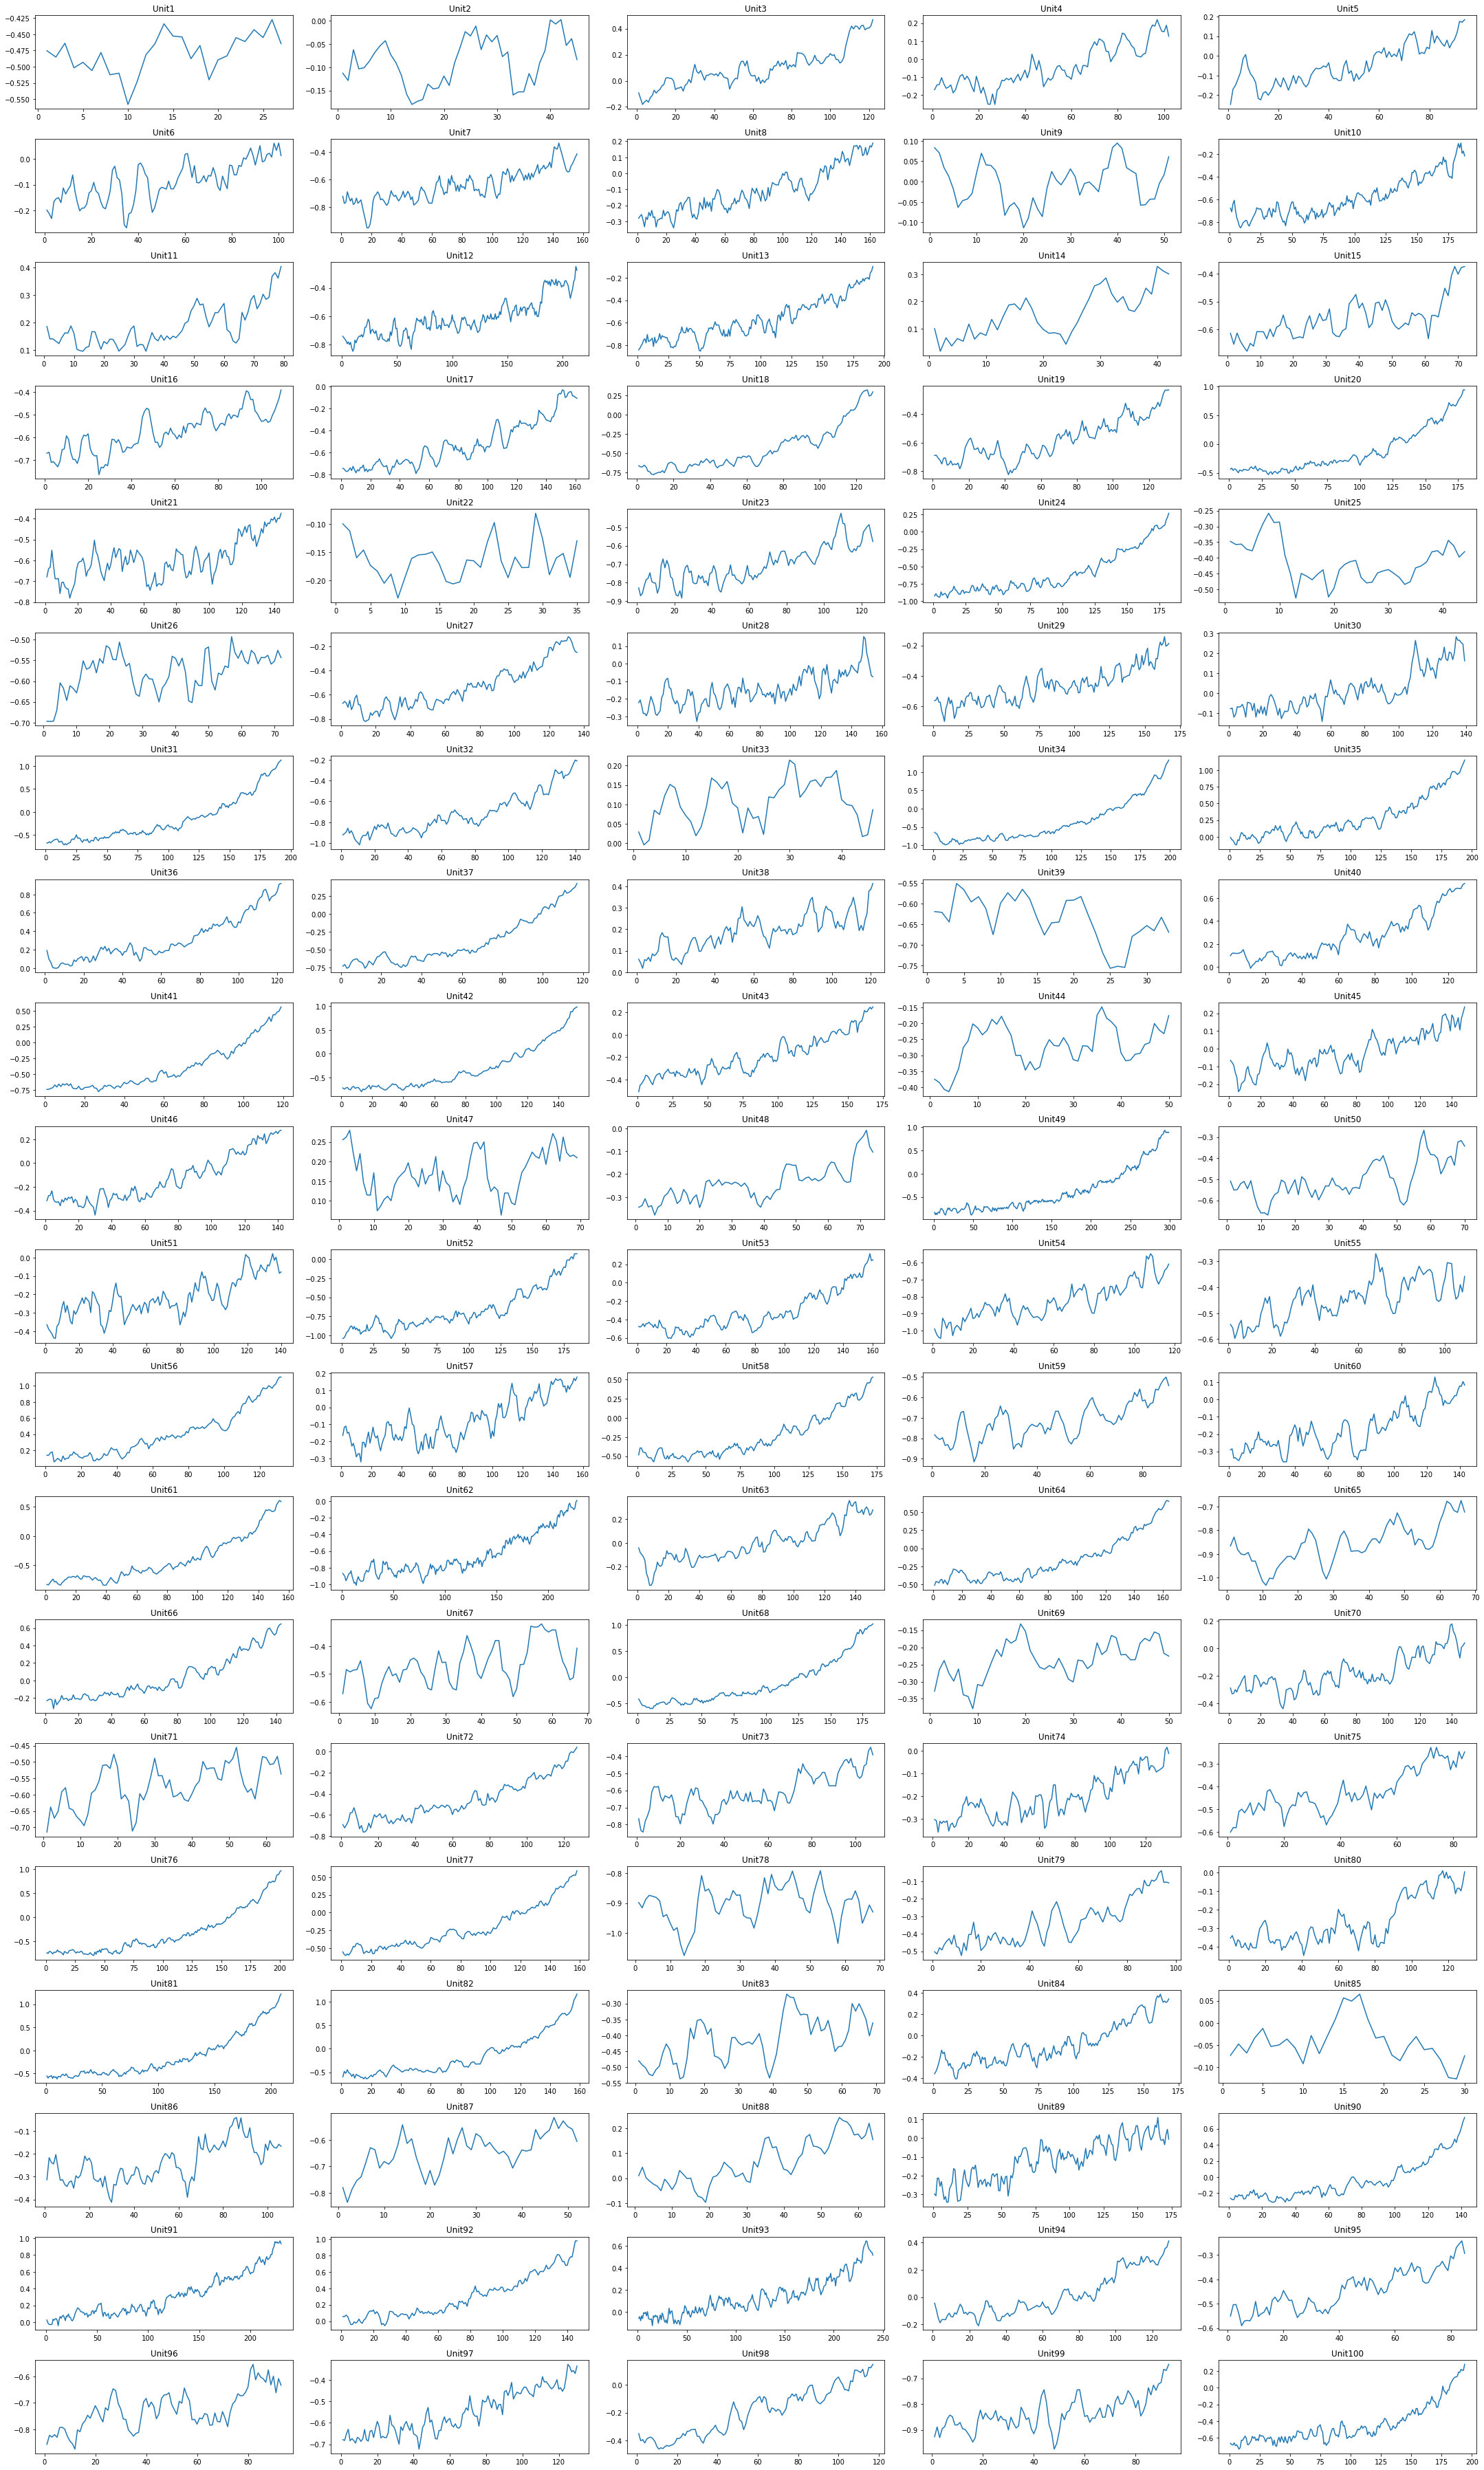

In [49]:
fig,ax = plt.subplots(nrows = 20, ncols = 5, figsize = (30,50))
ax = ax.ravel()
for i in range(0,100):
    sns.lineplot(data= pca_test_df[pca_test_df.UnitNumber == i+1], y='PC1', x= 'Cycle', ax = ax[i])
    ax[i].set_title('Unit'+str(i+1))
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
plt.tight_layout()

In order to predict the remaining useful lifetime, we should Fit an exponential model on test data using parameters as mean values and bounds as 25th and 75th percentile values of exponential models found using training data;

In [50]:
phi_vals = exp_param_df.phi
theta_vals = exp_param_df.theta
beta_vals = exp_param_df.beta
param_1 = [phi_vals.mean(), theta_vals.mean(), beta_vals.mean()]
param_1

[-0.4485811142716783, 0.04423880664513278, 0.020027005232685836]

In [51]:
lb = 25
ub = 75
phi_bounds = [np.percentile(phi_vals, lb), np.percentile(phi_vals, ub)]
theta_bounds = [np.percentile(theta_vals, lb), np.percentile(theta_vals, ub)]
beta_bounds = [np.percentile(beta_vals, lb), np.percentile(beta_vals, ub)]
bounds = ([phi_bounds[0], theta_bounds[0], beta_bounds[0]],
         [phi_bounds[1], theta_bounds[1], beta_bounds[1]])
bounds

([-0.7774273185274622, 0.030767657511902354, 0.016290515219582528],
 [-0.1470829849969346, 0.060007376149273414, 0.022950107486693072])

In [52]:
result_test_df = pd.DataFrame(columns= ["UnitNumber", "phi", "theta", "beta", "pred_RUL", "True_RUL"])
for i in pca_test_df.UnitNumber.unique():
    ht= pca_test_df.PC1[pca_test_df.UnitNumber == i]
    cycle = pca_test_df.Cycle[pca_test_df.UnitNumber == i]
    OptimizeResult = optimize.least_squares(residuals, param_1, bounds = bounds, args = (cycle, ht, degradation_model))
    phi, theta, beta = OptimizeResult.x
    total_cycle = np.log((threshold - phi) / theta) / beta
    RUL = total_cycle - cycle.max()
    result_test_df = result_test_df.append({'UnitNumber': i, 'phi': phi, 'theta' : theta, 'beta' : beta,
                                            'pred_RUL' : RUL, 'True_RUL' : y_true.RUL[y_true.UnitNumber == i].values[0]},
                                          ignore_index = True)
result_test_df.head()

UnitNumber       phi     theta      beta    pred_RUL  True_RUL
0         1.0 -0.557490  0.055556  0.022950  127.233699     112.0
1         2.0 -0.147083  0.033001  0.022950  121.412804      98.0
2         3.0 -0.147083  0.060007  0.018603   51.162774      69.0
3         4.0 -0.228240  0.060007  0.019036   69.984975      82.0
4         5.0 -0.216469  0.060007  0.019316   75.104584      91.0

Text(0, 0.5, 'True RUL')

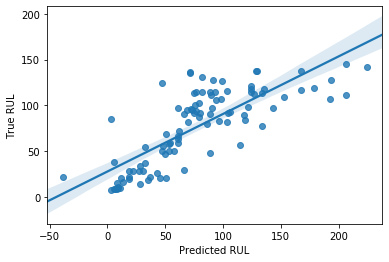

In [53]:
sns.regplot(x=result_test_df.pred_RUL, y=result_test_df.True_RUL)
plt.xlabel('Predicted RUL')
plt.ylabel('True RUL')

Text(0, 0.5, 'Remaining Useful Lifetime')

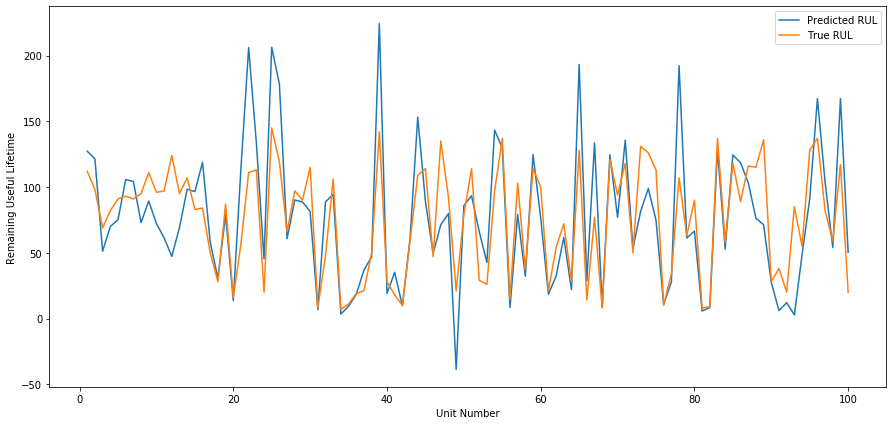

In [54]:
fig, ax= plt.subplots(figsize = (15,7))
sns.lineplot(x=result_test_df.UnitNumber, y=result_test_df.pred_RUL, label = "Predicted RUL")
sns.lineplot(x=result_test_df.UnitNumber, y=result_test_df.True_RUL, label = "True RUL")
plt.xlabel("Unit Number")
plt.ylabel("Remaining Useful Lifetime")

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

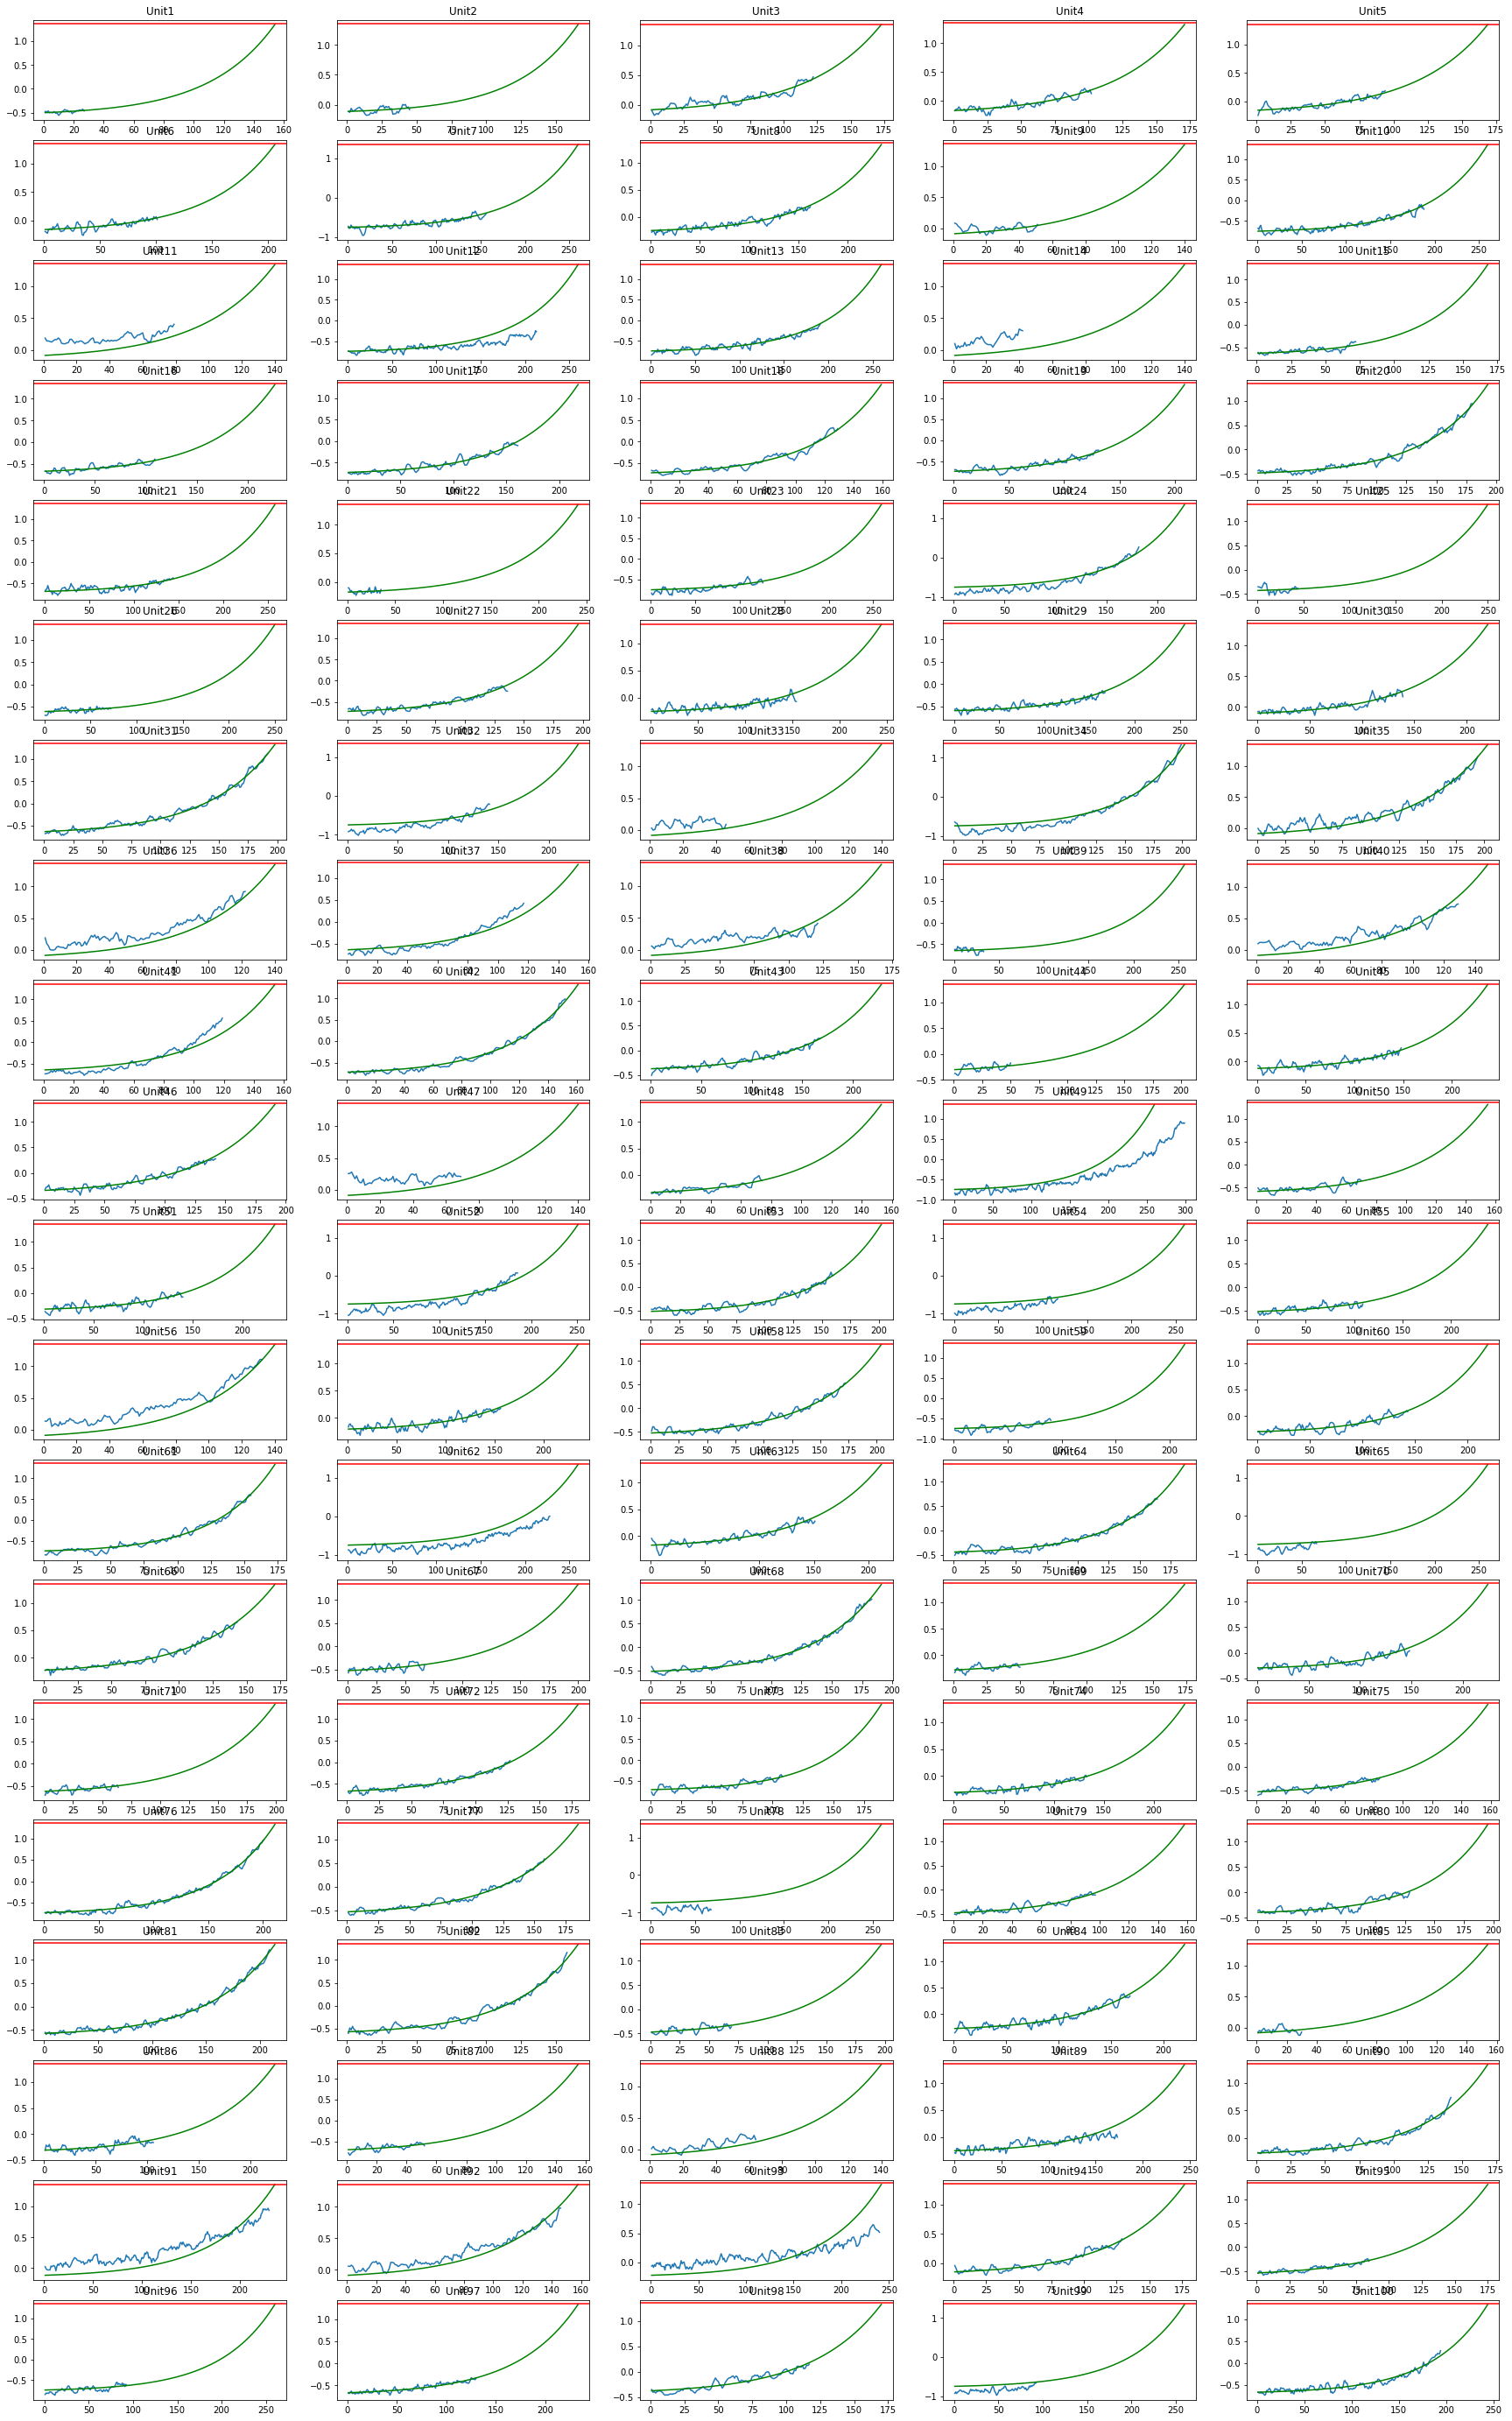

In [55]:
fig, ax = plt.subplots( nrows = 20, ncols = 5, figsize = (30,50))
ax = ax.ravel()
for i in range(0,100):
    phi = result_test_df.phi[result_test_df.UnitNumber == i+1].values[0]
    theta = result_test_df.theta[result_test_df.UnitNumber == i+1].values[0]
    beta = result_test_df.beta[result_test_df.UnitNumber == i+1].values[0]
    pred_RUL = result_test_df.pred_RUL[result_test_df.UnitNumber == i+1].values[0]
    cycle = pca_test_df.Cycle[pca_test_df.UnitNumber == i+1]
    total_cycle = [j for j in range(1, int(cycle.max() + pred_RUL +1))]
    pred_ht = degradation_model([phi, theta, beta], pd.Series(total_cycle))
    sns.lineplot(data = pca_test_df[pca_test_df.UnitNumber == i+1], x = 'Cycle', y = 'PC1', ax = ax[i])
    sns.lineplot(y = pred_ht, x = total_cycle, ax = ax[i], color = 'green')
    ax[i].axhline(threshold, color = 'r')
    ax[i].set_title('Unit'+str(i+1))
    ax[i].set_ylabel("")
    ax[i].set_xlabel("")
plt.tight_layout

In [56]:
mean_squared_error(result_test_df.True_RUL, result_test_df.pred_RUL)

1022.9832152091492

In [57]:
mean_absolute_error(result_test_df.True_RUL, result_test_df.pred_RUL)

22.84860558998449

In [58]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [59]:
mean_absolute_percentage_error(result_test_df.True_RUL, result_test_df.pred_RUL)

34.457658353274326